## Постановка задачи

### Данные

Даны `train.csv` и `test.csv`. Для обучения и валидации модели используется только `train.csv`. После сравнения различных подходов будет выбрана наилучшая модель, с использованием которой будут классифицированы новости из `test.csv` и сформирован финальный файл с предсказаниями `predictions.csv`

### Подход к решению задачи

В текущем блокноте рассмотрены различные модели машинного обучения и предобработки данных, начиная от более простого к сложному. Для подбора наилучших параметров используется `GridSearchCV`


**Тип задачи:** бинарная классификация, таргет (целевая перерменная) принимает одно из двух возможных значений

**Таргет:** 0 (не фейковая новость) и 1 (фейковая новость)

**Оценка качества моделей (по условию):**

- F1-macro - хорошо подходит для задачи классификации, показывает качество классификации в среднем по классам

- Roc-Auc - отражает качество модели при разных порогах решения и не зависит от баланса классов, помогает понять, хорошо ли справляется наша модель с детекцией положительных (1) и отрицательных (0) классов

### Общий пайплайн
1. Анализ обучающей выборки
2. Сравнение работы моделей на данных с базовой предобработкой и векторизацией Tf-Idf
3. Использование эмбеддингов и улучшение работы модели

## Установка необходимых библиотек и считывание данных

In [27]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from collections import Counter
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.decomposition import PCA
import joblib

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariadolgodvorova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mariadolgodvorova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
sns.set_theme("notebook")
sns.set_context("notebook", font_scale=1.3)

In [29]:
df_train = pd.read_csv('data/train.csv', sep='\t')

## Анализ обучающей выборки

In [30]:
df_train.head(3)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1


**Проверка отсутствующих значений**

In [31]:
df_train.isna().any()

title      False
is_fake    False
dtype: bool

Не найдено пропущенных значений, поэтому дополнительно их обрабатывать не нужно

**Распределение данных**

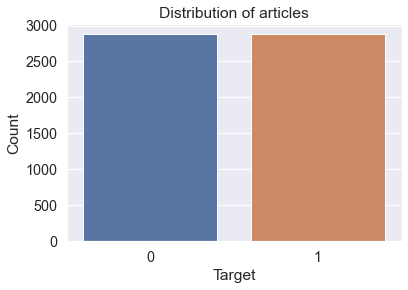

In [32]:
sns.countplot(x='is_fake', data=df_train)
plt.title('Distribution of articles')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

Распределение данных равномерное, поэтому балансировка классов не требуется

## Предобработка данных для бейзлайна

На этапе предобработки из стандартных этапов необходимо выполнить:
- токенизацию
- приведение к одному регистру
- лемматизацию
- удаление стоп-слов
Пунктуация и стемминг будут рассмотрены отдельно.

Как правило, тексты очищают от пунктуации, поскольку при решении определенных типов задач она не несет информации, однако для решения задачи детекции фейковых заголовков пунктуация может стать дополнительной фичей.

В статье [Detecting Fake News in Social Media Networks](https://www.sciencedirect.com/science/article/pii/S1877050918318210?ref=cra_js_challenge&fr=RR-1) авторы указывают на то, что заголовки с чрезмерным использованием восклицательных и вопросительных знаков с большей вероятностью будут фейковыми. Вероятно, можно будет использовать это как признак, но для начала необходимо посмотреть, встречается ли такое в наших данных.

Проверим, встречается ли подряд ? или !

In [33]:
# количество строк, где заголовки содержат минимум два ?
len(df_train[df_train['title'].str.contains('\?\?+')])

0

In [34]:
# количество строк, где заголовки содержат минимум два !
len(df_train[df_train['title'].str.contains('!!+')])

0

В выборке нет чрезмерного использования восклицательных или вопросительных знаков, фичей это послужить не может, поэтому очистим тексты от всей пунктуации.

Касаемо стемминга, решено его не применять. С одной стороны, стемминг повышает обобщающую способность моделей, но с другой -- теряется информация о контексте и используемый алгоритм может неправильно выделить основу.

In [35]:
def preprocess(df_col, stop_words):
    """
    Предобработка текстовых данных

    """

    # Токенизация
    df_col = df_col.apply(word_tokenize)

    # Приведение к нижнему регистру
    df_col = df_col.apply(lambda x: [word.lower() for word in x])

    # Удаление стоп-слов
    df_col = df_col.apply(lambda x: [word for word in x if word not in stop_words])

    # Удаление пунктуации
    df_col = df_col.apply(lambda x: [''.join(re.sub(r'[^\w\s]', '', word)) for word in x])

    return df_col

In [36]:
stopwords_rus = stopwords.words("russian")
df_train['title'] = preprocess(df_train.title, stopwords_rus)

In [37]:
df_train.head(3)

,title,is_fake
0,"[москвичу, владимиру, клутину, пришёл, счёт, в...",1
1,"[агент, кокорина, назвал, езду, встречке, жите...",0
2,"[госдума, рассмотрит, возможность, введения, с...",1


Необходимо применить векторизацию. Для бейзлайновой модели возьмем Tf-Idf и max_features = 4000 по умолчанию, чтобы слов было меньше, чем документов, поскольку в противном случае некоторые модели не смогут обучиться, а некоторые будут обучаться значительно дольше

In [38]:
def vectorize_title_column(df_col, max_features=4000):
    """
    Векторизация текстовых данных
    """
    vectorizer = TfidfVectorizer(max_features=max_features)
    return vectorizer.fit_transform(df_col.apply(lambda x: ' '.join(x)))

Финализируем обработку данных:
- После применения векторизации и train_test_split на данных части из df_train будет происходить обучение, а на части тестироваться качество работы модели (поэтому назовем `X_val` и `y_val`)
- Обработка df_test нужна для получения файла с финальными предсказаниями

In [39]:
X = vectorize_title_column(df_train.title)
y = df_train.is_fake.values

In [40]:
def split_train(X, y):
    # Разделение на train и val
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Обучающая выборка: {X_train.shape}, Валидационная выборка: {X_val.shape}")

    #Удостоверимся, что после разбиения сохранен баланс классов
    print(f"Классы обучающей выборки: {dict(Counter(y_train))}")
    print(f"Классы валидационной выборки: {dict(Counter(y_val))}")
    return X_train, X_val, y_train, y_val
X_train, X_val, y_train, y_val = split_train(X, y)

Обучающая выборка: (4606, 4000), Валидационная выборка: (1152, 4000)
Классы обучающей выборки: {1: 2289, 0: 2317}
Классы валидационной выборки: {0: 562, 1: 590}


Классы сбалансированы, данные предобработаны, можно переходить к обучению

# Обучение

Прежде чем перейти к обучению моделей создадим функцию для графика ROC-кривой  

In [18]:
def plot_roc_auc(model, X_val, y_val):
    """
    График ROC-AUC
    """
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    print("ROC AUC:", roc_auc)

    plt.figure()
    plt.plot(
        fpr, tpr, color='coral', lw=2, label="ROC curve (area = %0.2f)" % roc_auc
    )
    plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.title("ROC")
    plt.legend(loc="lower right")
    plt.show()

Поскольку `predictions.csv` должен содержать не только метки класса (0 или 1), но и вероятность, необходимо учесть, чтобы был доступен метод `predict_proba`

## Decision Trees

Для бейзлайна возьмем решающие деревья, они легко интерпретируемы и зачастую неплохо справляются с задачами классификации.

Сразу будем искать наиболее оптимальные параметры:
-  `max_depth` - малые значения помогают избежать переобучения за счет слишком простой модели, а большие позволяют модели захватывать более сложные зависимости в данных, но могут привести к переобучению
- `min_samples_split` - значение по умолчанию 2, попробуем добавить значения больше, они будут требовать для деления больше образцов, что снижает вероятность переобучения, но также может быть причиной недообучения
-  `min_samples_leaf` - значение по умолчанию 1, но такое может перевести к переобучению, поскольку это позволит любому узлу стать листом, если в нем есть хотя бы один образец. Стоит попробовать взять значения больше, так как это может помочь сгладить модель и избежать переобучения
- `criterion` - выбор более оптимального критерия

In [ ]:
def DT_best_params(X_train, X_val, y_train, y_val, pipeline):
    """
    Подбор гиперпараметров Decision Tree
    """
    param_grid = {
        'dt__max_depth': [3, 5, 10, 20],
        'dt__min_samples_split': [2, 5, 10],
        'dt__min_samples_leaf': [1, 2, 4],
        'dt__criterion': ['gini', 'entropy']
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best score (f1 macro):", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    grid_pred = best_model.predict(X_val)

    f1_macro = f1_score(y_val, grid_pred, average='macro')
    print("Test f1 macro:", f1_macro)

    return best_model

In [ ]:
pipe = Pipeline([
    ('dt', DecisionTreeClassifier())
])

best_model_DT = DT_best_params(X_train, X_val, y_train, y_val, pipe)

Best parameters: {'dt__criterion': 'gini', 'dt__max_depth': 20, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 5}
Best score (f1 macro): 0.5216430476448533
Test f1 macro: 0.5169369562141287


ROC AUC: 0.5948609686953374


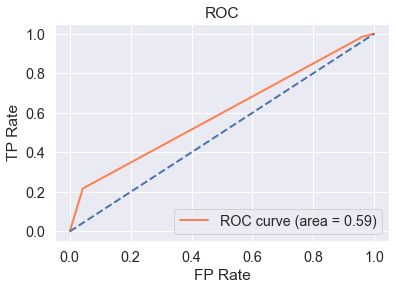

In [ ]:
plot_roc_auc(best_model_DT, X_val, y_val)

Модель работает недостаточно хорошо.

По графику ROC AUC видно, что модель имеет низкую способность качественно разделять классы, а значение f1 macro около 0.52 указывает на то, что модель плохо сбалансирована в плане точности и полноты для каждого из классов.

Алгоритм случайного леса представляет из себя беггинг над решающими деревьями и работает в целом лучше, поэтому в качестве следующей модели решено использовать его.

## Random Forest

Среди гиперпараметов выделим:

-  `n_estimators` - начнем со 100, данных не очень много и этого может быть достаточно, по значениям сможем понять, как увеличение числа деревьев влияет на модель
- `max_depth` - небольшие значения (возьмем как и для решающих деревьев 3 и 5) помогают уменьшить переобучение и повысить обобщающую способность модели. Также возьмем 10, что позволит модели улавливать более сложные зависимости, но стоит помнить, что увеличится риск переобучения
- `min_samples_leaf` - низкие значения могут позволить модели стать более гибкой, но могут привести к переобучению, а высокие -- делают модель более устойчивой, но есть риск недообучения

In [48]:
def RF_best_params(X_train, X_val, y_train, y_val, pipeline):
    """
    Подбор гиперпараметров Random Forest
    """
    param_grid = {
        'rf__n_estimators': [100, 200, 300],
        'rf__max_depth': [3, 5, 10],
        'rf__min_samples_leaf': [3, 5, 10]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best score (f1 macro):", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    grid_pred = best_model.predict(X_val)

    f1_macro = f1_score(y_val, grid_pred, average='macro')
    print("Test f1 macro:", f1_macro)

    return best_model

In [ ]:
pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

best_model_RF = RF_best_params(X_train, X_val, y_train, y_val, pipe)

Best parameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 300}
Best score (f1 macro): 0.6706520660193745
Test f1 macro: 0.6578349518042068


ROC AUC: 0.7928599433017672


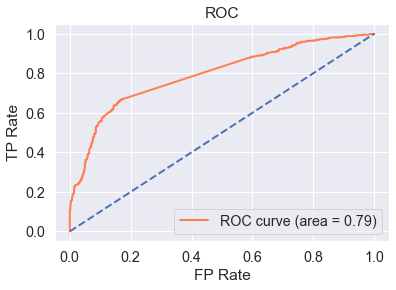

In [ ]:
plot_roc_auc(best_model_RF, X_val, y_val)

Алгоритм случайного леса справился неплохо, значение ROC AUC (почти 0.8) указывает на то, что модель имеет хорошую способность различать классы, значение f1 macro в целом свидетельствует о неплохой обобщающей способности.

Можно попробовать бустинг, так как модели с использованием градиентного бустинга исправляют ошибки в построении предыдущих деревьев и можно ожидать, что качество повысится. Выбран XGBoost

## XGBoost

Попробуем следующие гиперпараметры:
- `max_depth` - по аналогии с моделями, используемыми ранее
- `n_estimators` - по аналогии с RF
- `min_child_weight` -  помогает избежать переобучения, поскольку дерево не будет делиться, если сумма весов в листе меньше заданного значения (логика похожа на `min_samples_leaf` для RF, но только тут вес, а не количество образцов)
- `learning_rate` - позволяет найти баланс между скоростью обучения и стабильностью модели. Меньшие значения скорости обучения сделают процесс обучения более медленным, но модели станут менее подвержены переобучению и более стабильны
- `gamma` - увеличение значения гиперпараметра добавляет дополнительные условия для разбиения

In [ ]:
def XGB_best_params(X_train, X_val, y_train, y_val, pipeline):
    """
    Подбор гиперпараметров XGBoost
    """
    param_grid = {
        'xgb__max_depth': [None, 3, 5, 10],
        'xgb__learning_rate': [0.01, 0.05, 0.1],
        'xgb__n_estimators': [100, 200, 300],
        'xgb__min_child_weight': [3, 5, 7],
        'xgb__gamma': [0, 0.1, 0.2]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best score (f1 macro):", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    grid_pred = best_model.predict(X_val)

    f1_macro = f1_score(y_val, grid_pred, average='macro')
    print("Test f1 macro:", f1_macro)

    return best_model

In [ ]:
pipe = Pipeline([
    ('xgb', XGBClassifier(eval_metric='logloss', use_label_encoder=False))
])

best_model_XGB = XGB_best_params(X_train, X_val, y_train, y_val, pipe)

Best parameters: {'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 300}
Best score (f1 macro): 0.6464467564635813
Test f1 macro: 0.6880742811777294


ROC AUC: 0.7509183304179986


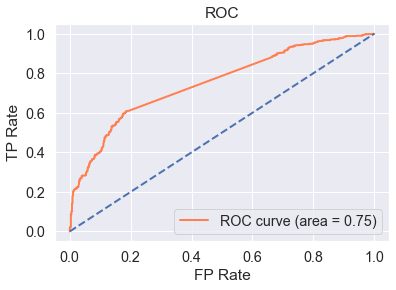

In [ ]:
plot_roc_auc(best_model_XGB, X_val, y_val)

f1 macro незначительно возросло в сравнении с алгоритмом случайного леса (0.65 vs 0.68), в то время как ROC AUC напротив снизился (0.79 vs 0.75).

Так, применение XGBoost немного улучшило баланс точности и полноты по сравнению со случайным лесом, но при этом незначительно снизилась общая способность модели различать классы

Стоит попробовать алгоритм, не основанный на деревьях

## Support Vector Machine

Посмотрим, как с задачей справится SVM, поскольку как правило он показывает хорошие результаты на небольших наборах данных со сложной структурой. К данным не применялось скалирование, поскольку векторизация Tf-Idf и так предполагает нормализацию

Гиперпараметры:

- `C` -  нахождение баланса между максимизацией ширины гиперплоскости и минимизацией ошибки классификации
- `kernel` - ядро для преобразования в новые размерности, позволит лучше разделять данные, которые не получится разделить линейно
- `gamma` - коэффициент ядра, значения позволяют определить, какой метод масштабирования будет наиболее эффективным

In [41]:
def SVC_best_params(X_train, X_val, y_train, y_val, pipeline):
    """
    Подбор гиперпараметров SVC
    """
    param_grid = {
        'svc__C': [0.1, 1, 10],
        'svc__kernel': ['linear', 'poly', 'rbf'],
        'svc__gamma': ['scale', 'auto']
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best score (f1 macro):", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    grid_pred = best_model.predict(X_val)

    f1_macro = f1_score(y_val, grid_pred, average='macro')
    print("Test f1 macro:", f1_macro)

    return best_model

In [42]:
pipe = Pipeline([
    ('svc', SVC(probability=True)) # чтобы использовать predict_proba
])

best_model_SVC = SVC_best_params(X_train, X_val, y_train, y_val, pipe)

Best parameters: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best score (f1 macro): 0.8134524372389391
Test f1 macro: 0.82282641801892


ROC AUC: 0.8969328668797878


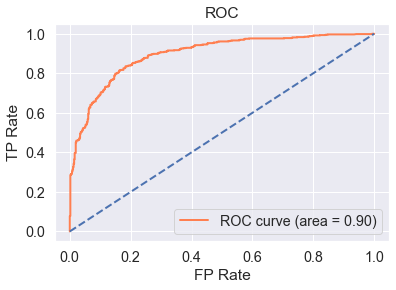

In [43]:
plot_roc_auc(best_model_SVC, X_val, y_val)

SVC показал пока что лучшие результаты - значение f1 macro отражает сбалансированную производительность в плане точности и полноты для всех классов, а по ROC AUC можно сказать, что модель имеет высокую обобщающую способность и хорошо разграничивает классы

Из методов машинного обучения рассмотрены основные модели (среди относительно продвинутых, не считая бейзлайна), далее имеет смысл изменить способ предобработки и добавить эмбеддинги

# Эмбеддинги

Изменим предобработку и получим эмбеддинги. Попробуем обучить эмбеддинги на наших данных, хоть их и мало, но, учитывая, что времени хватает, попробовать стоит. Если получится что-то хорошее, то будет лучше предобученной модели

In [34]:
df_train = pd.read_csv('data/train.csv', sep='\t')

In [35]:
def preprocess_for_word2vec(df_col):
    """
    Предобработка текстовых данных для использования с Word2Vec.
    """
    # Удаление специальных символов и лишних пробелов
    df_col = df_col.apply(lambda x: re.sub(r'[^\w\s]', '', x))
    df_col = df_col.apply(lambda x: re.sub(r'\s+', ' ', x))
    return df_col

In [36]:
df_train['title'] = preprocess_for_word2vec(df_train.title)

In [43]:
def train_word2vec(df_col, vector_size=300, window=3, min_count=1, epochs=10):
    """
    Обучение Word2Vec
    """
    sentences = df_col.apply(lambda x: x.split()) if isinstance(df_col, pd.Series) else [x.split() for x in df_col]

    model = Word2Vec(sentences=sentences, vector_size=vector_size, window=window, min_count=min_count, sg=1, epochs=epochs)

    return model

In [44]:
w2v_model = train_word2vec(df_train['title'])

In [45]:
def vectorize_text_word2vec(df_col, w2v_model):
    """
    Векторизация текстовых данных с Word2Vec
    """
    def get_mean_vector(words):
        words = [word for word in words if word in w2v_model.wv]
        if len(words) >= 1:
            return np.mean(w2v_model.wv[words], axis=0)
        else:
            return np.zeros(w2v_model.vector_size)

    vectorized_col = df_col.apply(lambda x: get_mean_vector(x))
    return np.vstack(vectorized_col)

In [46]:
X = vectorize_text_word2vec(df_train.title, w2v_model)
y = df_train.is_fake.values

In [47]:
X_train, X_val, y_train, y_val = split_train()

Обучающая выборка: (4606, 300), Валидационная выборка: (1152, 300)
Классы обучающей выборки: {1: 2289, 0: 2317}
Классы валидационной выборки: {0: 562, 1: 590}


Посмотрим, как справятся модели на данных с эмбеддингами. Будем использовать SVM, поскольку модель лучше всего показала, и Random Forest, метрики которой были в целом неплохими (не XGBoost, поскольку метрики схожи с RF, но бустинг значительно дольше работает)

### SVM на данных с эмбеддингами Word2Vec

In [25]:
pipe = Pipeline([
    ('svc', SVC(probability=True)) # чтобы использовать predict_proba
])

best_model_SVC_embs = SVC_best_params(X_train, X_val, y_train, y_val, pipe)

Best parameters: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best score (f1 macro): 0.6031746517863569
Test f1 macro: 0.6075461436486624


ROC AUC: 0.688726702454913


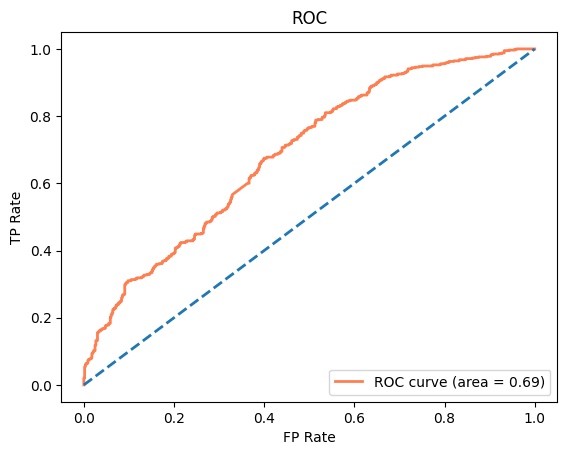

In [29]:
plot_roc_auc(best_model_SVC_embs, X_val, y_val)

### Random Forest на данных с эмбеддингами Word2Vec

In [49]:
pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

best_model_RF_embs = RF_best_params(X_train, X_val, y_train, y_val, pipe)

Best parameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 100}
Best score (f1 macro): 0.6489827933580696
Test f1 macro: 0.6623966742398608


ROC AUC: 0.7287019723746909


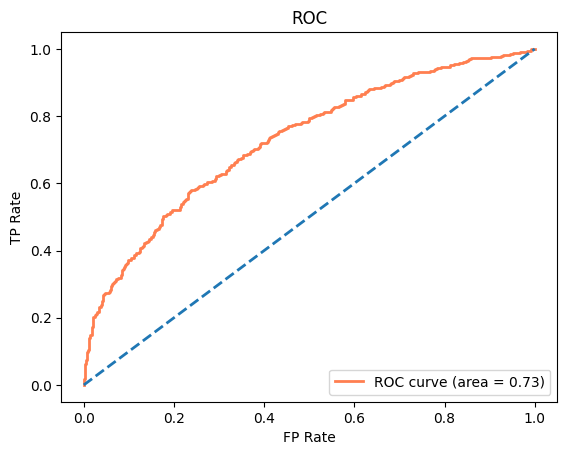

In [50]:
plot_roc_auc(best_model_RF_embs, X_val, y_val)

Обе модели стали хуже, значит, обученные на наших данных word2vec эмбеддинги использовать не стоит - возможно, не хватило данных для обучения качественных эмбеддингов (а у нас не очень много данных)

Возьмем предобученную модель fasttext и применим PCA

In [64]:
# модель FastText для новостей, тк у нас новостные заголовки
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [88]:
df_train = pd.read_csv('data/train.csv', sep='\t')

In [89]:
def vectorize_title_column_fasttext(df_col, model):
    """
    Векторизация текстовых данных с использованием предобученных эмбеддингов FastText
    """
    # эмбеддинги
    embeddings = []
    # эмбеддинги для каждой строки
    for text in df_col:
        words = text.split()
        word_vecs = []

        for word in words:
            if word in model:
                word_vecs.append(model[word])

        if word_vecs:
            embedding = np.mean(word_vecs, axis=0)
        else:
            # если ни одно из слов не было найдено в модели, то используем нулевой вектор
            embedding = np.zeros(model.vector_size)
        embeddings.append(embedding)

    return np.array(embeddings)

In [101]:
X = vectorize_title_column_fasttext(df_train['title'], fasttext_model)
y = df_train.is_fake.values

In [102]:
X.shape

(5758, 300)

Необходимо подобрать n_components для PCA

In [103]:
pca = PCA().fit(X)

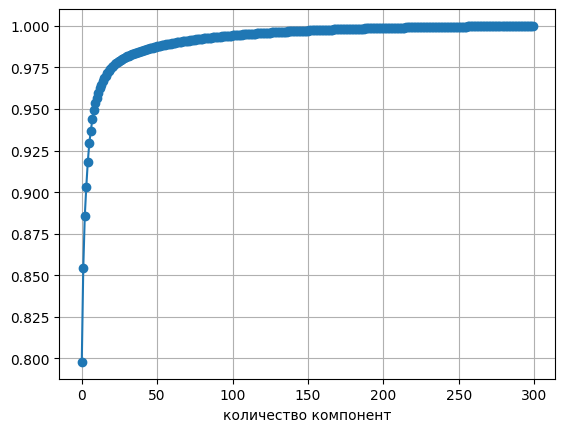

In [104]:
# какая доля дисперсии данных объясняется каждой главной компонентой
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cum_var, marker='o')
plt.xlabel('количество компонент')
plt.grid()
plt.show()

In [105]:
# Поиск оптимального количества компонент
n_comp_opt = np.argmax(cum_var >= 0.95) + 1
n_comp_opt

10

In [106]:
pca = PCA(n_components=n_comp_opt)
X = pca.fit_transform(X)

In [107]:
X_train, X_val, y_train, y_val = split_train()

Обучающая выборка: (4606, 10), Валидационная выборка: (1152, 10)
Классы обучающей выборки: {1: 2289, 0: 2317}
Классы валидационной выборки: {0: 562, 1: 590}


## SVM на данных с эмбеддингами FastText и понижением размерности

In [108]:
pipe = Pipeline([
    ('svc', SVC(probability=True)) # чтобы использовать predict_proba
])

best_model_SVC_embs = SVC_best_params(X_train, X_val, y_train, y_val, pipe)

Best parameters: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best score (f1 macro): 0.6031746517863569
Test f1 macro: 0.6075461436486624


ROC AUC: 0.6887116231377044


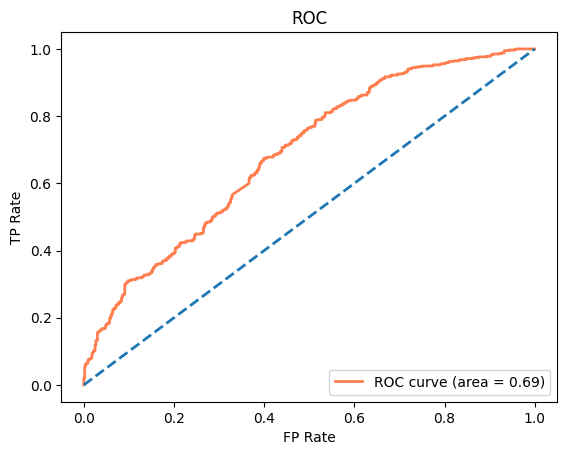

In [109]:
plot_roc_auc(best_model_SVC_embs, X_val, y_val)

## Random forest на данных с эмбеддингами FastText и понижением размерности

In [110]:
pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

best_model_RF_embs = RF_best_params(X_train, X_val, y_train, y_val, pipe)

Best parameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 100}
Best score (f1 macro): 0.6504619409849364
Test f1 macro: 0.6627461632486759


ROC AUC: 0.7232402436817661


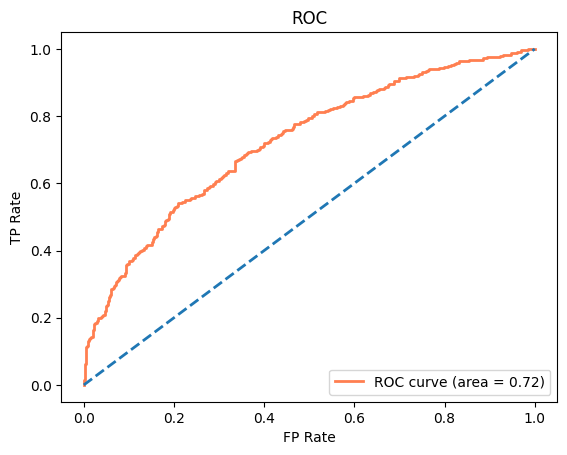

In [111]:
plot_roc_auc(best_model_RF_embs, X_val, y_val)

### Выводы и получение предсказаний

Наилучшим образом отработал SVM на данных, векторизованных путем Tf-Idf со следующими гиперпараметрами:
```
{'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
```

In [173]:
df_test = pd.read_csv('data/test.csv', sep='\t')

In [174]:
df['title'] = preprocess(df_test.title, stopwords_rus)
X = vectorize_title_column(df['title'] )

In [175]:
is_fake = best_model_SVC.predict(X)

In [176]:
prob_fake = best_model_SVC.predict_proba(X)[:, 1]

In [177]:
len(prob_fake) == len(is_fake)

True

In [180]:
df_test['is_fake'] = is_fake
df_test['prob_fake'] = prob_fake
# predictions.csv
df_test.to_csv('predictions.csv', sep='\t', encoding='utf-8', index=False)

In [184]:
df_test.head(10)

,title,is_fake,prob_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1,0.547686
1,Ночью под Минском на президентской горе Белара...,1,0.917283
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1,0.718369
3,"Сельская церковь, собравшая рекордно низкое ко...",0,0.300526
4,Акции Google рухнули после объявления о переза...,1,0.888900
5,Курс доллара вырос до исторического максимума,1,0.815658
6,ОПЕК назвала оптимальный уровень цен на нефть,0,0.433180
7,Российская авиакомпания откроет рейсы в Тбилис...,1,0.647911
8,Швейцарская горнолыжница расстреляна в доме ро...,0,0.242860
9,Учреждена театральная премия имени Гарольда Пи...,0,0.212308


In [183]:
joblib.dump(pipe, 'svc_model.joblib')

['svc_model.joblib']